# Wasserstein GAN with Gradient Penalty (WGAN-GP)

### Goals
I am now going to build a Wasserstein GAN with Gradient Penalty (WGAN-GP) that solves some of the stability issues with the GANs that you have been using up until this point. Specifically, I will use a special kind of loss function known as the W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.




## Generator and Critic

Please note that the "discriminator" is now being referred to as the Critic. 

#### Packages and Visualizations

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Critic

In [3]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a critic block of DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the critic: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training Initializations




In [4]:
n_epochs = 100
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, critic, and optimizers.

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


## Gradient Penalty


In [6]:

# GRADED FUNCTION: get_gradient
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        
        inputs= mixed_images,
        outputs= mixed_scores,
        
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


In [7]:
# UNIT TEST
# DO NOT MODIFY THIS
def test_get_gradient(image_shape):
    real = torch.randn(*image_shape, device=device) + 1
    fake = torch.randn(*image_shape, device=device) - 1
    epsilon_shape = [1 for _ in image_shape]
    epsilon_shape[0] = image_shape[0]
    epsilon = torch.rand(epsilon_shape, device=device).requires_grad_()
    gradient = get_gradient(crit, real, fake, epsilon)
    assert tuple(gradient.shape) == image_shape
    assert gradient.max() > 0
    assert gradient.min() < 0
    return gradient

gradient = test_get_gradient((256, 1, 28, 28))
print("Success!")

Success!


The second function you need to complete is to compute the gradient penalty given the gradient. First, you calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, you calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

Again, you will need to fill in the code wherever you see *None*. There are hints below that you can view if you need help and there is a test function in the next block for you to test your solution.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">gradient_penalty</font></code></b>
</font>
</summary>


1.   Make sure you take the mean at the end.
2.   Note that the magnitude of each gradient has already been calculated for you.

</details>


In [14]:

# GRADED FUNCTION: gradient_penalty

def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    
    
    penalty = ((1 - gradient_norm)**2).mean()
    
    
    return penalty

In [15]:
# UNIT TEST
def test_gradient_penalty(image_shape):
    bad_gradient = torch.zeros(*image_shape)
    bad_gradient_penalty = gradient_penalty(bad_gradient)
    assert torch.isclose(bad_gradient_penalty, torch.tensor(1.))

    image_size = torch.prod(torch.Tensor(image_shape[1:]))
    good_gradient = torch.ones(*image_shape) / torch.sqrt(image_size)
    good_gradient_penalty = gradient_penalty(good_gradient)
    assert torch.isclose(good_gradient_penalty, torch.tensor(0.))

    random_gradient = test_get_gradient(image_shape)
    random_gradient_penalty = gradient_penalty(random_gradient)
    assert torch.abs(random_gradient_penalty - 1) < 0.1

test_gradient_penalty((256, 1, 28, 28))
print("Success!")

Success!


## Losses


In [18]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    
    gen_loss = -(crit_fake_pred).mean()
    
    return gen_loss

In [19]:
# UNIT TEST
assert torch.isclose(
    get_gen_loss(torch.tensor(1.)), torch.tensor(-1.0)
)

assert torch.isclose(
    get_gen_loss(torch.rand(10000)), torch.tensor(-0.5), 0.05
)

print("Success!")

Success!


## Critic Loss


In [32]:

# GRADED FUNCTION: get_crit_loss
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    
    crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + (gp).mean()*c_lambda
    
    
    return crit_loss

In [33]:
# UNIT TEST
assert torch.isclose(
    get_crit_loss(torch.tensor(1.), torch.tensor(2.), torch.tensor(3.), 0.1),
    torch.tensor(-0.7)
)
assert torch.isclose(
    get_crit_loss(torch.tensor(20.), torch.tensor(-20.), torch.tensor(2.), 10),
    torch.tensor(60.)
)

print("Success!")

Success!


## Training 


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1, step 500: Generator loss: 6.624661021200474, critic loss: -109.41834783288536


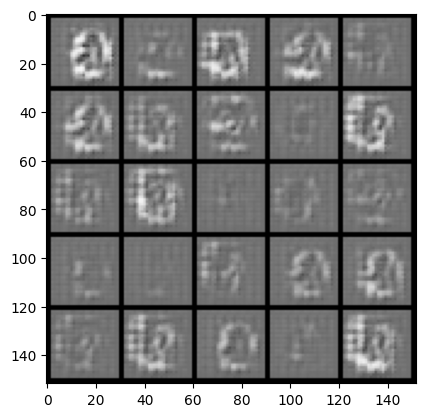

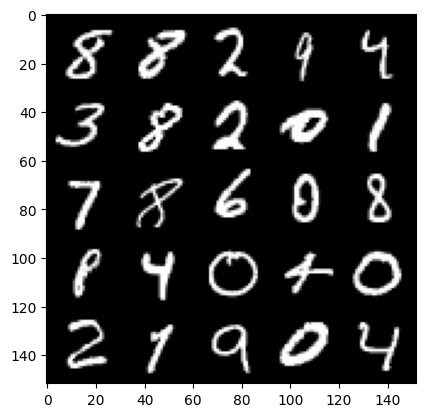

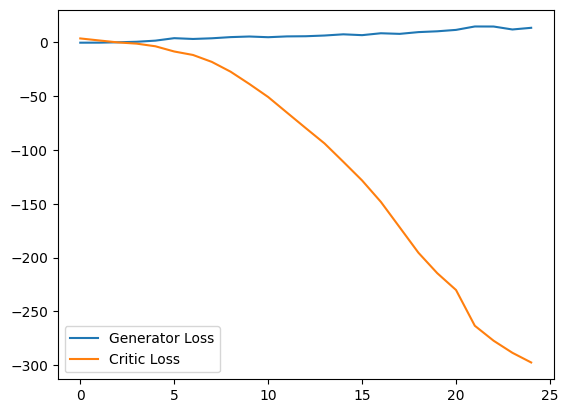

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2, step 1000: Generator loss: -9.246548445522786, critic loss: -279.7485241020199


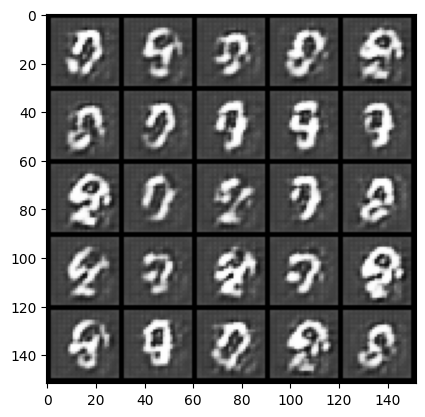

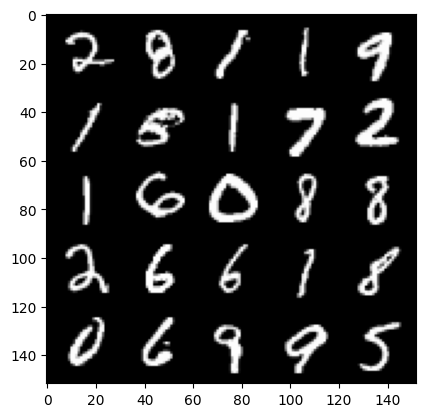

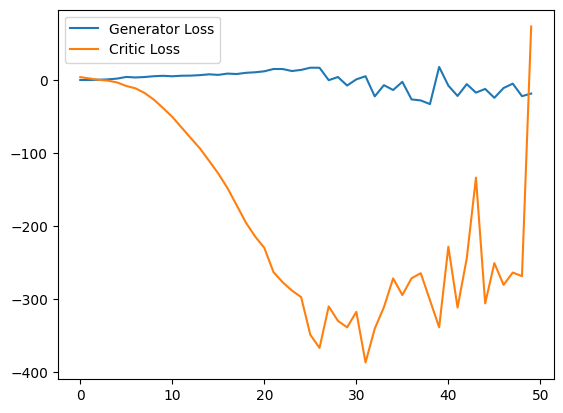

In [ ]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1
